In [1]:
import os
import torch
import random
import pydicom
import numpy as np
import pandas as pd
from PIL import Image
from scipy import stats
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
import torch.nn.functional as F
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")
torch.manual_seed(42)
np.random.seed(42)

In [2]:
pehlay_data = pd.read_csv('../../../../Datasets/rawCAIFOS/custom/labels_demo.csv')
pehlay_data['file_names'] = '../../../../Datasets/rawCAIFOS/custom/images/' + pehlay_data['img_name']

more_data = pd.read_csv('../../../../Datasets/newCAIFOS/labels_demo.csv')
more_data['file_names'] = '../../../../Datasets/newCAIFOS/custom/' + more_data['img_name']

In [3]:
train_data = pd.concat([pehlay_data, more_data], ignore_index = True)
train_data.shape

(2285, 10)

In [4]:
train_fns, train_lbs, train_age, train_weight, train_height = train_data['file_names'], train_data['fat_mass'], train_data['age'], train_data['weight'], train_data['height']
print("Training set", train_fns.shape)

Training set (2285,)


In [5]:
# Dataset class
class CustomDataset(Dataset):
    def __init__(self, file_names, labels, age, weight, height, transform = None, target_size = (287, 800)):
        self.file_names = file_names
        self.labels = labels
        self.age = age
        self.weight = weight
        self.height = height
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        label = self.labels[idx]
        age = self.age[idx]
        weight = self.weight[idx]
        height = self.height[idx]

        dicom_data = pydicom.dcmread(file_name)
        image = dicom_data.pixel_array.astype(np.float32)
        image = Image.fromarray(image)
        image = image.resize(self.target_size)

        if self.transform:
            image = self.transform(image)

        age = torch.tensor(age, dtype=torch.float32)
        weight = torch.tensor(weight, dtype=torch.float32)
        height = torch.tensor(height, dtype=torch.float32)

        return image, age, weight, height, label

train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
])

In [6]:
train_dataset = CustomDataset(train_fns, train_lbs, train_age, train_weight, train_height, transform = train_transform)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

Training dataset:


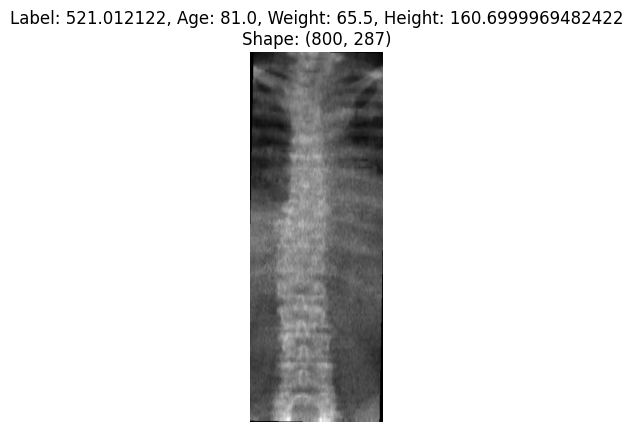

In [7]:
def display_sample(loader, dataset_type):

    images, ages, weights, heights, labels  = next(iter(loader))
    images = images.numpy()
    
    image = np.squeeze(images[0])

    label = labels[0].item()
    age = ages[0].item()
    weight = weights[0].item()
    height = heights[0].item()
    image_shape = image.shape    
    plt.imshow(image, cmap = 'gray')  
    plt.title(f"Label: {label}, Age: {age}, Weight: {weight}, Height: {height}\nShape: {image_shape}")
    plt.axis('off')
    plt.show()

print("Training dataset:")
display_sample(train_loader, "train")

In [ ]:
class TabTransformer(nn.Module):
    def __init__(self, num_features, dim_embedding=32, num_heads=2, num_layers=1):
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(num_features, dim_embedding)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1) 
        x = self.transformer(x)
        return x.mean(dim=1) 

class MobileNetV2Regression(nn.Module):
    def __init__(self, num_classes=1, pretrained=True, train_backbone=False):
        super(MobileNetV2Regression, self).__init__()
        mobilenet_v2 = models.mobilenet_v2(pretrained=pretrained)
        self.features = mobilenet_v2.features
        if not train_backbone:
            for param in self.features.parameters():
                param.requires_grad = False

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.Dropout(0.5),
            nn.Linear(512, 64)  
        )

    def forward(self, x):
        x = x.expand(-1, 3, -1, -1) 
        x = self.features(x)
        x = self.fc(x)
        return x

class AttentionFusion(nn.Module):
    def __init__(self, dim_image, dim_tabular):
        super(AttentionFusion, self).__init__()
        self.attention = nn.Linear(dim_image + dim_tabular, 2)

    def forward(self, image_embedding, tabular_embedding):
        concatenated = torch.cat([image_embedding, tabular_embedding], dim=1)
        weights = F.softmax(self.attention(concatenated), dim=1)
        combined_embedding = (
            weights[:, 0:1] * image_embedding + weights[:, 1:2] * tabular_embedding
        )
        return combined_embedding

class OneModel(nn.Module):
    def __init__(self, num_tabular_features, pretrained=True, train_backbone=True):
        super(OneModel, self).__init__()
        self.image_model = MobileNetV2Regression(pretrained=pretrained, train_backbone=train_backbone)
        self.tabular_model = TabTransformer(num_features=num_tabular_features, dim_embedding = 64)
        self.fusion = AttentionFusion(dim_image = 64, dim_tabular = 64)

        self.classifier = nn.Sequential(
            nn.Linear(64, 1),
        )

    def forward(self, image, tabular_data):
        image_embedding = self.image_model(image)
        tabular_embedding = self.tabular_model(tabular_data)
        combined_embedding = self.fusion(image_embedding, tabular_embedding)
        output = self.classifier(combined_embedding)
        return output

In [9]:
model = OneModel(num_tabular_features = 3, pretrained = True)

In [10]:
def rmse_loss(y_pred, y_true):
    return torch.sqrt(F.mse_loss(y_pred, y_true))

def mape_loss(y_pred, y_true):
    return mean_absolute_percentage_error(y_true.cpu().numpy(), y_pred.cpu().detach().numpy())

In [11]:
def initialize_model():
    model = OneModel(num_tabular_features = 3, pretrained = True)
    model = model.to('cuda')
    optimizer = optim.Adam(model.parameters(), lr = 1e-3)
    print('--New Model--')
    return model, optimizer

In [12]:
def train_model_kfold(model, dataset, k = 10, epochs = 20, lr = 1e-3, device = 'cuda'):
    kfold = KFold(n_splits=k, shuffle = True, random_state = 42)
    
    fold_results = []
    os.makedirs('./rooba_verify/med_losses/att_tabmob9/folds', exist_ok = True)
    results_file = './rooba_verify/med_losses/att_tabmob9/training.txt'

    with open(results_file, 'w') as f:
        f.write("K-Fold Cross-Validation Results\n")
        f.write("=" * 50 + "\n")

    for fold, (train_val_index, test_index) in enumerate(kfold.split(dataset)):
        print(f"Training fold {fold+1}/{k}")
        
        train_val_subset = Subset(dataset, train_val_index)
        test_subset = Subset(dataset, test_index)

        train_index, val_index = train_test_split(train_val_index, test_size = 1/k, shuffle = True, random_state = 42)
        train_subset = Subset(dataset, train_index)
        val_subset = Subset(dataset, val_index)

        # Test subset 
        test_file_paths = [dataset.file_names[idx] for idx in test_index]
        test_labels = [dataset.labels[idx] for idx in test_index]
        test_age = [dataset.age[idx] for idx in test_index]
        test_weight = [dataset.weight[idx] for idx in test_index]
        test_height = [dataset.height[idx] for idx in test_index]
        test_df = pd.DataFrame({'file_paths': test_file_paths, 'labels': test_labels, 'age': test_age, 'weight': test_weight, 'height': test_height})
            
        test_df.to_csv(f'./rooba_verify/med_losses/att_tabmob9/folds/test_subset_fold{fold+1}.csv', index=False)

        # Train subset
        train_file_paths = [dataset.file_names[idx] for idx in train_index]
        train_labels = [dataset.labels[idx] for idx in train_index]
        train_age = [dataset.age[idx] for idx in train_index]
        train_weight = [dataset.weight[idx] for idx in train_index]
        train_height = [dataset.height[idx] for idx in train_index]
        train_df = pd.DataFrame({'file_paths': train_file_paths, 'labels': train_labels, 'age': train_age, 'weight': train_weight, 'height': train_height})
        train_df.to_csv(f'./rooba_verify/med_losses/att_tabmob9/folds/train_subset_fold{fold+1}.csv', index=False)

        # Validation subset
        val_file_paths = [dataset.file_names[idx] for idx in val_index]
        val_labels = [dataset.labels[idx] for idx in val_index]
        val_age = [dataset.age[idx] for idx in val_index]
        val_weight = [dataset.weight[idx] for idx in val_index]
        val_height = [dataset.height[idx] for idx in val_index]
        val_df = pd.DataFrame({'file_paths': val_file_paths, 'labels': val_labels, 'age': val_age, 'weight': val_weight, 'height': val_height})
        val_df.to_csv(f'./rooba_verify/med_losses/att_tabmob9/folds/val_subset_fold{fold+1}.csv', index=False)

        print(f"Fold {fold+1}: Training size = {len(train_subset)}, Validation size = {len(val_subset)}, Test size = {len(test_subset)}")        
        
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size = 32, shuffle = True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size = 32, shuffle = False)
        test_loader = torch.utils.data.DataLoader(test_subset, batch_size = 32, shuffle  =False)
        
        # Reinitialize
        model, optimizer = initialize_model()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.5)
        
        fold_train_rmse = 0.0
        fold_val_rmse = 0.0
        fold_train_mape = 0.0
        fold_val_mape = 0.0
        
        # Training loop for each fold
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            total_rmse = 0.0
            total_mape = 0.0
            
            for images, ages, weights, heights, labels in train_loader:
                images = images.to(device, dtype=torch.float32)
                ages = ages.to(device, dtype=torch.float32)
                weights = weights.to(device, dtype=torch.float32)
                heights = heights.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)

                tabular_data = torch.stack((ages, weights, heights), dim=1)

                optimizer.zero_grad()
                outputs = model(images, tabular_data)
                loss_rmse = rmse_loss(outputs.squeeze(), labels)
                loss_mape = mape_loss(outputs.squeeze(), labels)

                loss_rmse.backward()
                optimizer.step()

                running_loss += loss_rmse.item()
                total_rmse += loss_rmse.item()
                total_mape += loss_mape.item()

            scheduler.step(total_rmse)
            avg_train_rmse = total_rmse / len(train_loader)
            avg_train_mape = total_mape / len(train_loader)

            # Validation loop
            model.eval()
            val_loss = 0.0
            val_rmse = 0.0
            val_mape = 0.0

            with torch.no_grad():
                for images, ages, weights, heights, labels in val_loader:
                    images = images.to(device, dtype=torch.float32)
                    ages = ages.to(device, dtype=torch.float32)
                    weights = weights.to(device, dtype=torch.float32)
                    heights = heights.to(device, dtype=torch.float32)
                    labels = labels.to(device, dtype=torch.float32)

                    tabular_data = torch.stack((ages, weights, heights), dim=1)

                    outputs = model(images, tabular_data)

                    loss_rmse = rmse_loss(outputs.squeeze(), labels)
                    loss_mape = mape_loss(outputs.squeeze(), labels)

                    val_loss += loss_rmse.item()
                    val_rmse += loss_rmse.item()
                    val_mape += loss_mape.item()

            avg_val_rmse = val_rmse / len(val_loader)
            avg_val_mape = val_mape / len(val_loader)

            print(f"Epoch [{epoch+1}/{epochs}] - "
                  f"Train RMSE: {avg_train_rmse:.4f}, MAPE: {avg_train_mape:.4f}  "
                  f"Val RMSE: {avg_val_rmse:.4f}, MAPE: {avg_val_mape:.4f}")
            
            fold_train_rmse += avg_train_rmse
            fold_val_rmse += avg_val_rmse
            fold_train_mape += avg_train_mape
            fold_val_mape += avg_val_mape
        
        # Testing
        model.eval()
        test_rmse = 0.0
        test_mape = 0.0

        with torch.no_grad():
            for images, ages, weights, heights, labels in test_loader:
                images = images.to(device, dtype=torch.float32)
                ages = ages.to(device, dtype=torch.float32)
                weights = weights.to(device, dtype=torch.float32)
                heights = heights.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)

                tabular_data = torch.stack((ages, weights, heights), dim=1)

                outputs = model(images, tabular_data)

                loss_rmse = rmse_loss(outputs.squeeze(), labels)
                loss_mape = mape_loss(outputs.squeeze(), labels)

                test_rmse += loss_rmse.item()
                test_mape += loss_mape.item()

        avg_test_rmse = test_rmse / len(test_loader)
        avg_test_mape = test_mape / len(test_loader)

        print(f"Fold {fold+1} - "
              f"Train RMSE: {fold_train_rmse/epochs:.4f}, MAPE: {fold_train_mape/epochs:.4f} - "
              f"Val RMSE: {fold_val_rmse/epochs:.4f}, MAPE: {fold_val_mape/epochs:.4f} - "
              f"Test RMSE: {avg_test_rmse:.4f}, MAPE: {avg_test_mape:.4f}")
        
        os.makedirs('./rooba_verify/med_models/att_tabmob9/', exist_ok = True)
        torch.save(model.state_dict(), f'./rooba_verify/med_models/att_tabmob9/fold{fold+1}.pth')

        fold_results.append({
            "fold": fold + 1,
            "train_rmse": fold_train_rmse / epochs,
            "val_rmse": fold_val_rmse / epochs,
            "test_rmse": avg_test_rmse,
            "train_mape": fold_train_mape / epochs,
            "val_mape": fold_val_mape / epochs,
            "test_mape": avg_test_mape
        })
    
        with open(results_file, 'a') as f:
            f.write(f"Fold {fold+1} - Train RMSE: {fold_train_rmse / epochs:.4f}, MAPE: {fold_train_mape / epochs:.4f} - ")
            f.write(f"Val RMSE: {fold_val_rmse / epochs:.4f}, MAPE: {fold_val_mape / epochs:.4f} - ")
            f.write(f"Test RMSE: {avg_test_rmse:.4f}, MAPE: {avg_test_mape:.4f}\n")

    avg_train_rmse = sum(result["train_rmse"] for result in fold_results) / k
    avg_val_rmse = sum(result["val_rmse"] for result in fold_results) / k
    avg_test_rmse = sum(result["test_rmse"] for result in fold_results) / k
    avg_train_mape = sum(result["train_mape"] for result in fold_results) / k
    avg_val_mape = sum(result["val_mape"] for result in fold_results) / k
    avg_test_mape = sum(result["test_mape"] for result in fold_results) / k

    with open(results_file, 'a') as f:
        f.write("\nOverall Averages\n")
        f.write("=" * 50 + "\n")
        f.write(f"Train RMSE: {avg_train_rmse:.4f}, MAPE: {avg_train_mape:.4f}\n")
        f.write(f"Val RMSE: {avg_val_rmse:.4f}, MAPE: {avg_val_mape:.4f}\n")
        f.write(f"Test RMSE: {avg_test_rmse:.4f}, MAPE: {avg_test_mape:.4f}\n")

    print(f"\nOverall Average - Train RMSE: {avg_train_rmse:.4f}, MAPE: {avg_train_mape:.4f} - ")
    print(f"Val RMSE: {avg_val_rmse:.4f}, MAPE: {avg_val_mape:.4f} - Test RMSE: {avg_test_rmse:.4f}, MAPE: {avg_test_mape:.4f}")

In [13]:
train_model_kfold(model, train_dataset, epochs = 25, lr = 1e-3, device = 'cuda')

Training fold 1/10
Fold 1: Training size = 1850, Validation size = 206, Test size = 229
--New Model--
Epoch [1/25] - Train RMSE: 267.3142, MAPE: 0.5073  Val RMSE: 276.9832, MAPE: 0.4999
Epoch [2/25] - Train RMSE: 161.8672, MAPE: 0.3121  Val RMSE: 143.7808, MAPE: 0.2803
Epoch [3/25] - Train RMSE: 148.3365, MAPE: 0.2826  Val RMSE: 172.1192, MAPE: 0.3156
Epoch [4/25] - Train RMSE: 156.3351, MAPE: 0.2863  Val RMSE: 161.7856, MAPE: 0.2884
Epoch [5/25] - Train RMSE: 140.7595, MAPE: 0.2661  Val RMSE: 190.6074, MAPE: 0.4366
Epoch [6/25] - Train RMSE: 140.2421, MAPE: 0.2608  Val RMSE: 228.9558, MAPE: 0.5618
Epoch [7/25] - Train RMSE: 139.7569, MAPE: 0.2600  Val RMSE: 154.1902, MAPE: 0.3572
Epoch [8/25] - Train RMSE: 134.9385, MAPE: 0.2506  Val RMSE: 161.9922, MAPE: 0.2586
Epoch [9/25] - Train RMSE: 131.0140, MAPE: 0.2458  Val RMSE: 132.1243, MAPE: 0.2770
Epoch [10/25] - Train RMSE: 123.1038, MAPE: 0.2302  Val RMSE: 145.2347, MAPE: 0.2635
Epoch [11/25] - Train RMSE: 115.7243, MAPE: 0.2186  Val R

#### Test on a fold

0.8133662016160168


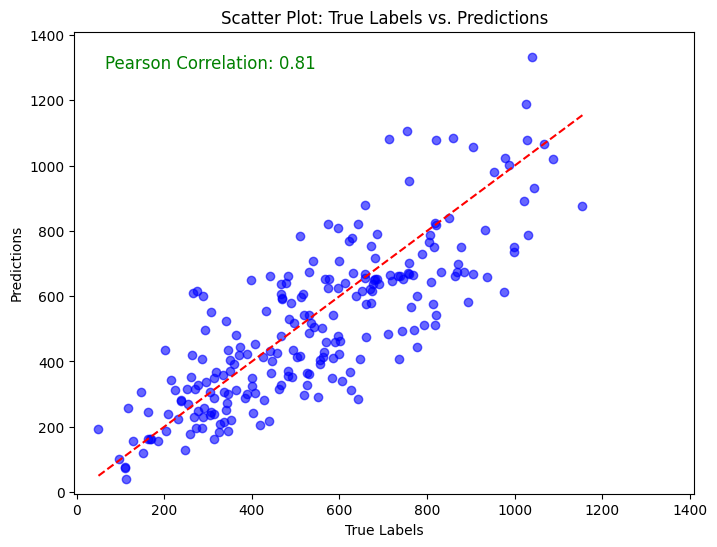

In [14]:
model = OneModel(num_tabular_features = 3, pretrained = True)
model.load_state_dict(torch.load('./rooba_verify/med_models/att_tabmob9/fold1.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_data = pd.read_csv('./rooba_verify/med_losses/att_tabmob9/folds/test_subset_fold1.csv')
test_data['file_paths'] = '../../../' + test_data['file_paths']
test_fns, test_lbs, test_age, test_weight, test_height = test_data['file_paths'], test_data['labels'], test_data['age'], test_data['weight'], test_data['height']
test_dataset = CustomDataset(test_fns, test_lbs, test_age, test_weight, test_height, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

def get_predictions(model, loader, device):
    true_labels = []
    predictions = []

    with torch.no_grad():
        for images, ages, weights, heights, labels in test_loader:
            images = images.to(device, dtype=torch.float32)
            ages = ages.to(device, dtype=torch.float32)
            weights = weights.to(device, dtype=torch.float32)
            heights = heights.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)

            tabular_data = torch.stack((ages, weights, heights), dim = 1) 
            
            outputs = model(images, tabular_data)

            true_labels.extend(labels.view(-1).cpu().numpy())
            predictions.extend(outputs.view(-1).cpu().numpy())

    return true_labels, predictions

predictions, actuals = get_predictions(model, test_loader, device)    

plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, color='blue', alpha = 0.6)
plt.plot(
    [min(actuals), max(actuals)],
    [min(actuals), max(actuals)],
    color='red',
    linestyle='--'
)
plt.xlim(-5, 1410)
plt.ylim(-5, 1410)

corr_coefficient, _ = pearsonr(actuals, predictions)
print(corr_coefficient)
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Scatter Plot: True Labels vs. Predictions')
plt.text(
    0.05, 0.95, f'Pearson Correlation: {corr_coefficient:.2f}',
    transform=plt.gca().transAxes, fontsize = 12, verticalalignment = 'top', color = 'green')
plt.show()

#### Test on a all-fold

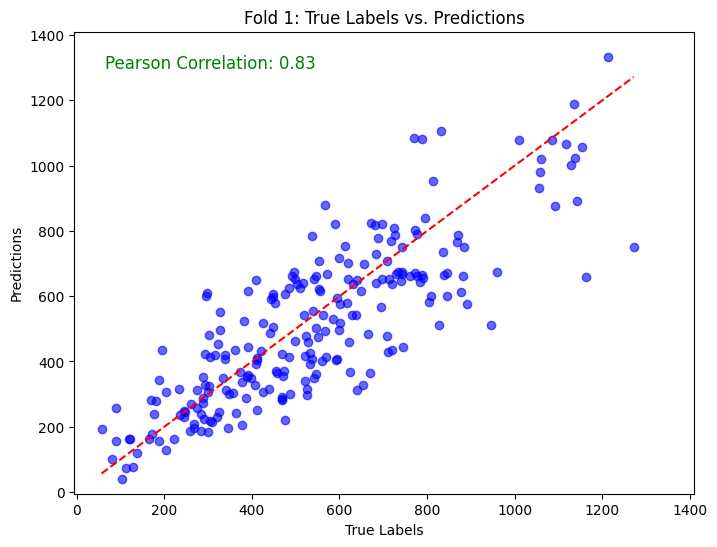

Fold 1 - Pearson Correlation: 0.83


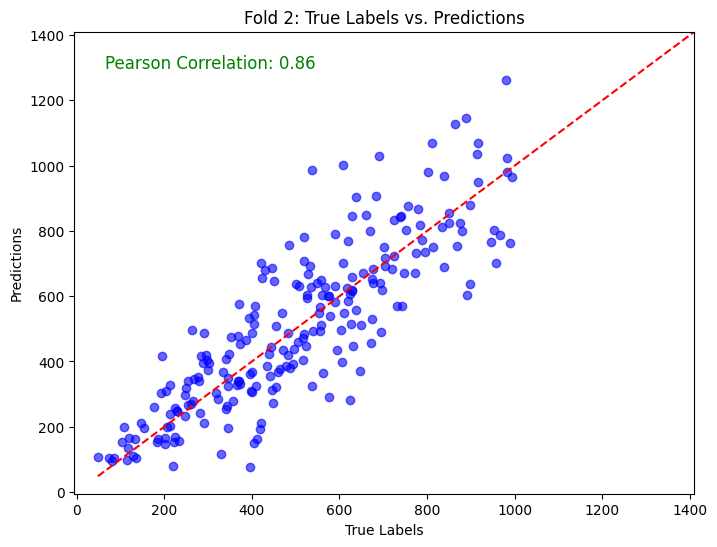

Fold 2 - Pearson Correlation: 0.86


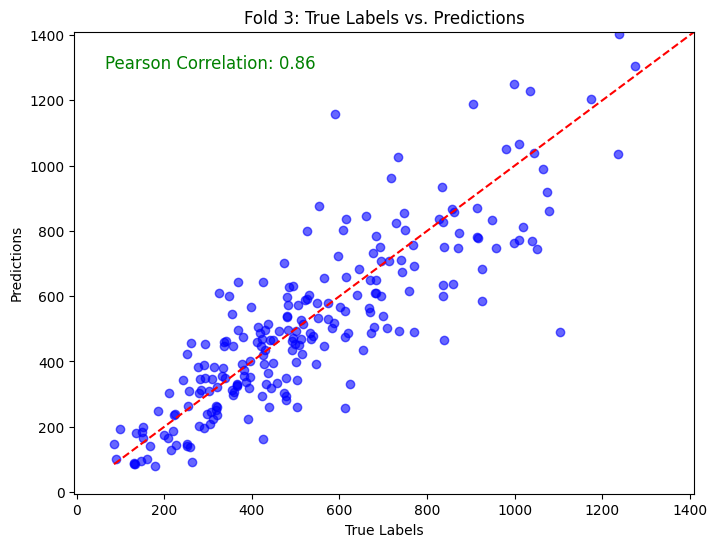

Fold 3 - Pearson Correlation: 0.86


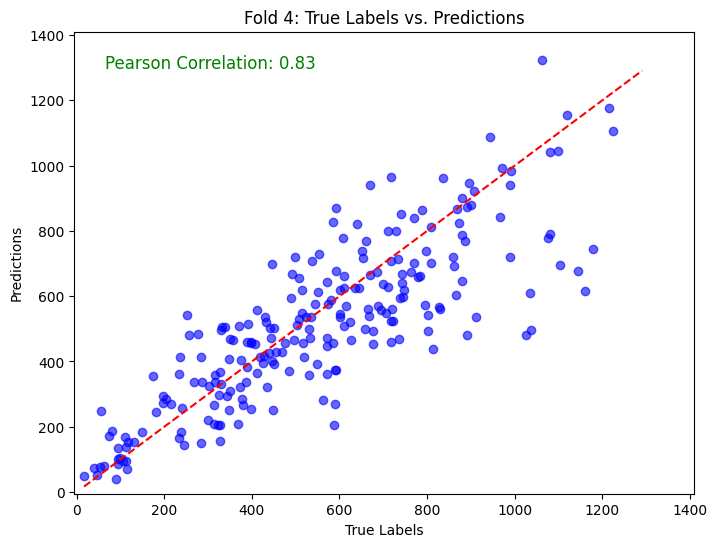

Fold 4 - Pearson Correlation: 0.83


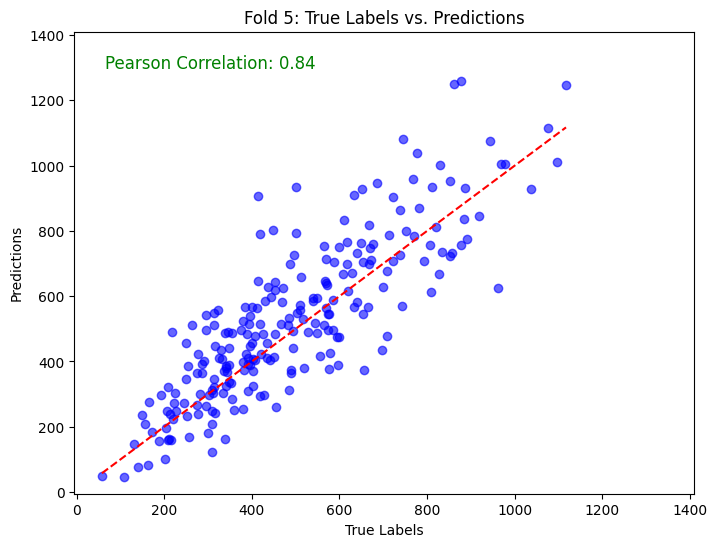

Fold 5 - Pearson Correlation: 0.84


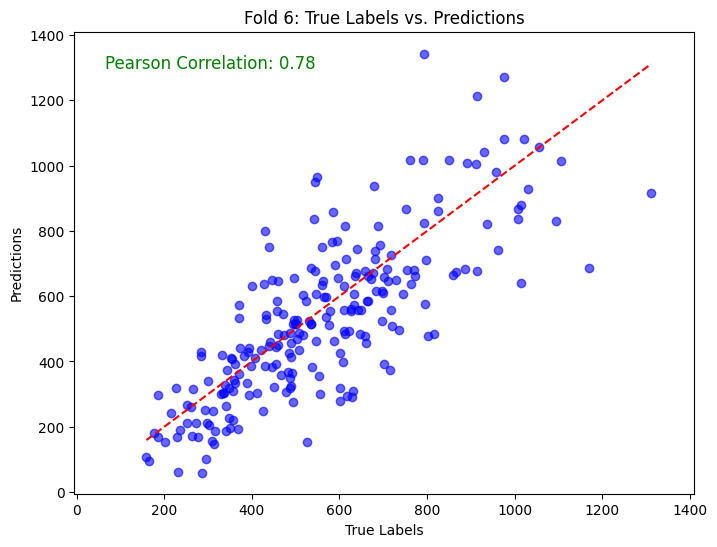

Fold 6 - Pearson Correlation: 0.78


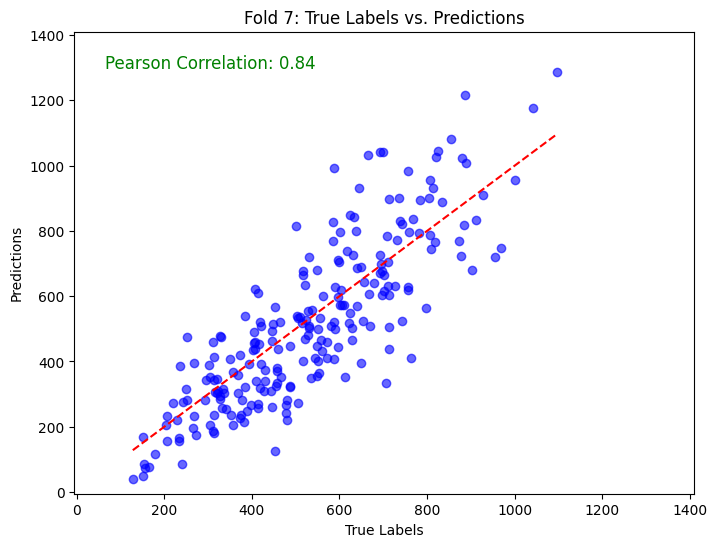

Fold 7 - Pearson Correlation: 0.84


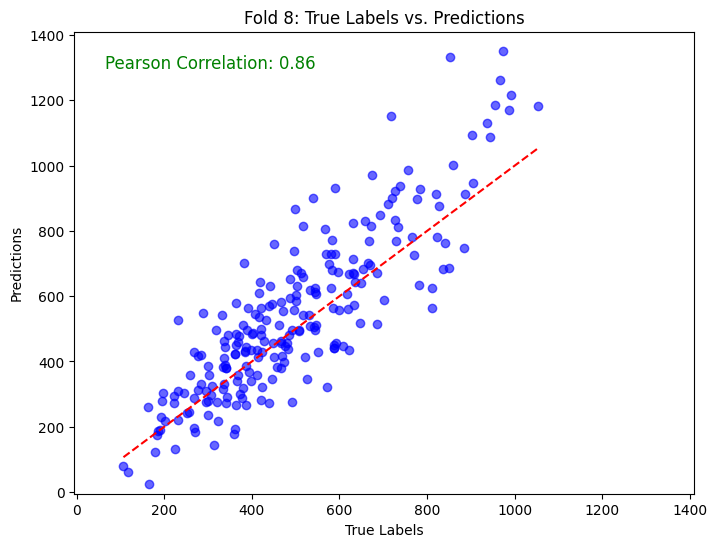

Fold 8 - Pearson Correlation: 0.86


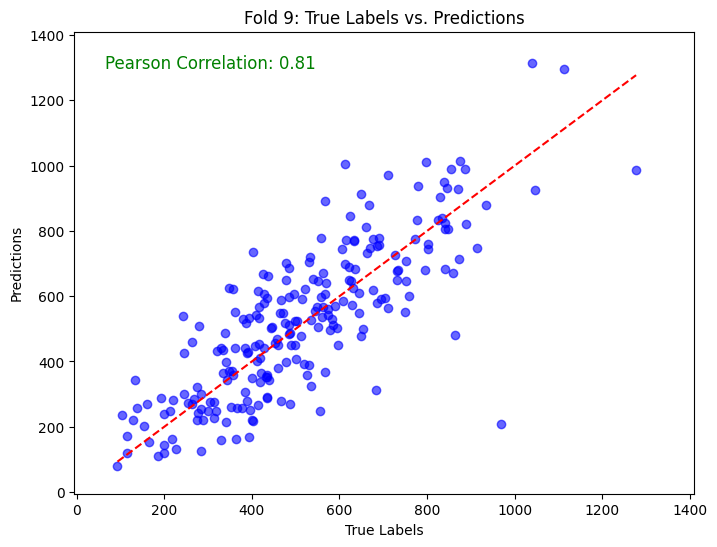

Fold 9 - Pearson Correlation: 0.81


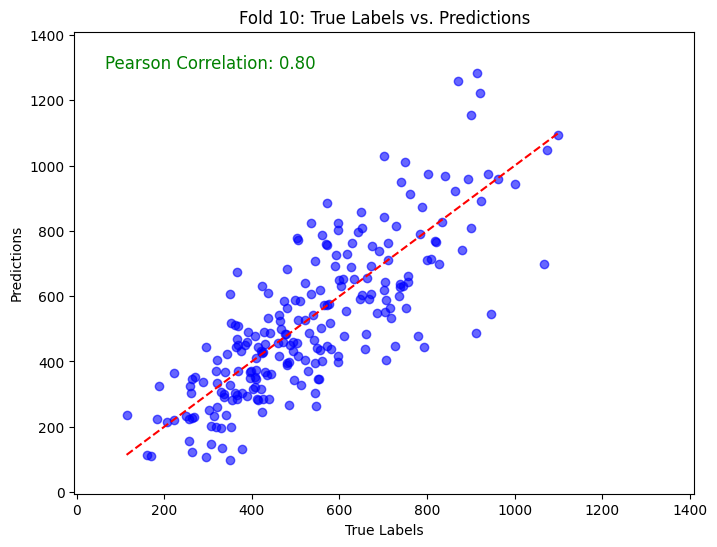

Fold 10 - Pearson Correlation: 0.80


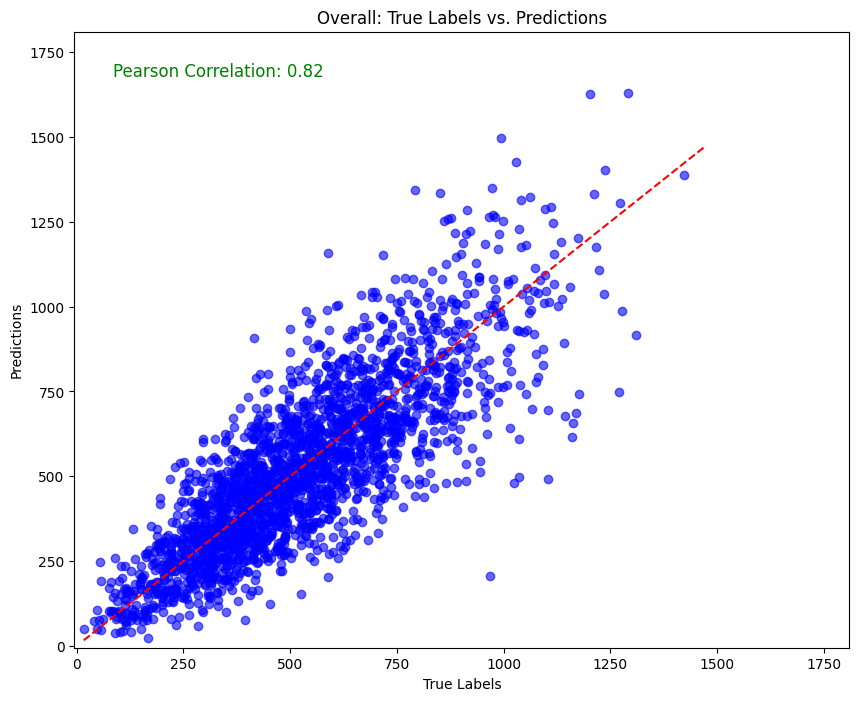

Overall Pearson Correlation: 0.82


In [15]:
all_predictions = []
all_actuals = []

# Placeholder DataFrame for saving predictions
results_df = pd.DataFrame(columns=['file_name', 'label', 'prediction'])

num_folds = 10
for fold in range(1, num_folds + 1):
    model_path = f'./rooba_verify/med_models/att_tabmob9/fold{fold}.pth'
    model = OneModel(num_tabular_features=3, pretrained=True)
    model.load_state_dict(torch.load(model_path))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_data_path = f'./rooba_verify/med_losses/att_tabmob9/folds/test_subset_fold{fold}.csv'
    test_data = pd.read_csv(test_data_path)
    test_data['file_paths'] = '../../../' + test_data['file_paths']
    test_fns, test_lbs, test_age, test_weight, test_height = (
        test_data['file_paths'], 
        test_data['labels'], 
        test_data['age'], 
        test_data['weight'], 
        test_data['height']
    )
    
    test_dataset = CustomDataset(test_fns, test_lbs, test_age, test_weight, test_height, transform=transforms.ToTensor())
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    
    
    predictions, actuals = get_predictions(model, test_loader, device)
    
    # Append results to placeholders
    all_predictions.extend(predictions)
    all_actuals.extend(actuals)
    results_fold = pd.DataFrame({
        'file_name': test_fns,
        'label': actuals,
        'prediction': predictions
    })
    results_df = pd.concat([results_df, results_fold], ignore_index=True)

    corr_coefficient, _ = pearsonr(actuals, predictions)
    
    # Scatterplot for the fold
    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predictions, color='blue', alpha=0.6)
    plt.plot(
        [min(actuals), max(actuals)],
        [min(actuals), max(actuals)],
        color='red',
        linestyle='--')
    
    plt.xlim(-5, 1410)
    plt.ylim(-5, 1410)
    plt.xlabel('True Labels')
    plt.ylabel('Predictions')
    plt.title(f'Fold {fold}: True Labels vs. Predictions')
    plt.text(
        0.05, 0.95, f'Pearson Correlation: {corr_coefficient:.2f}',
        transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='green')
    plt.show()
    
    print(f'Fold {fold} - Pearson Correlation: {corr_coefficient:.2f}')

# Scatterplot for the entire dataset
plt.figure(figsize=(10, 8))
plt.scatter(all_actuals, all_predictions, color='blue', alpha=0.6)
plt.plot(
    [min(all_actuals), max(all_actuals)],
    [min(all_actuals), max(all_actuals)],
    color='red',
    linestyle='--'
)
plt.xlim(-5, 1810)
plt.ylim(-5, 1810)
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.title('Overall: True Labels vs. Predictions')
overall_corr_coefficient, _ = pearsonr(all_actuals, all_predictions)
plt.text(
    0.05, 0.95, f'Pearson Correlation: {overall_corr_coefficient:.2f}',
    transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='green')
plt.show()

print(f'Overall Pearson Correlation: {overall_corr_coefficient:.2f}')


In [16]:
# results_df.to_csv('predictions.csv', index = False)